# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

September 27, 2025

This tutorial demonstrates the usage of **nbragg** to model and fit Bragg-edge transmission spectra of an iron powder.

Repository: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

> 💡 **Tip:** Run cells in order. Sections are intentionally short and task-oriented.

# Installation
Install directly from GitHub:

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

> Use `--upgrade` to update an existing install.

In [1]:
import nbragg

# Quick start
Minimal end-to-end example:
1. load data
2. define material
3. build model
4. fit
5. plot.

This example uses the default Rietveld fitting method, which accumulates parameters across stages. We also set custom fitting stages to control the refinement process.

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

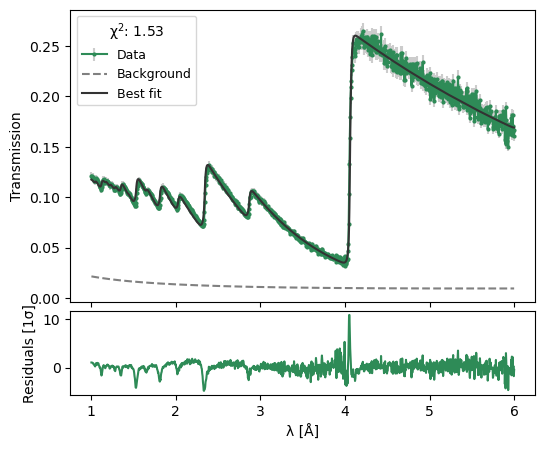

In [2]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")            # read data
xs = nbragg.CrossSection(iron="Fe_sg229_Iron-alpha.ncmat")                      # define sample
model = nbragg.TransmissionModel(xs, vary_background=True, vary_response=True)   # define model
result = model.fit(data)                                                         # perform fit
result.plot();                                                                   # plot results

In [3]:
result

In [4]:
data = nbragg.Data.from_transmission("iron_powder_transmission.csv")

The data is available as a table via `data.table`. Use `data.plot()` for a quick look.

In [5]:
data.table

,wavelength,trans,err
0,0.501098,0.148315,0.004449
1,0.505493,0.147728,0.004432
2,0.509889,0.147725,0.004432
3,0.514284,0.148043,0.004441
4,0.518680,0.148369,0.004451
...,...,...,...
2156,9.977258,0.050633,0.001519
2157,9.982328,0.043011,0.001291
2158,9.986135,0.103448,0.003104
2159,9.991219,0.062500,0.001875


<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

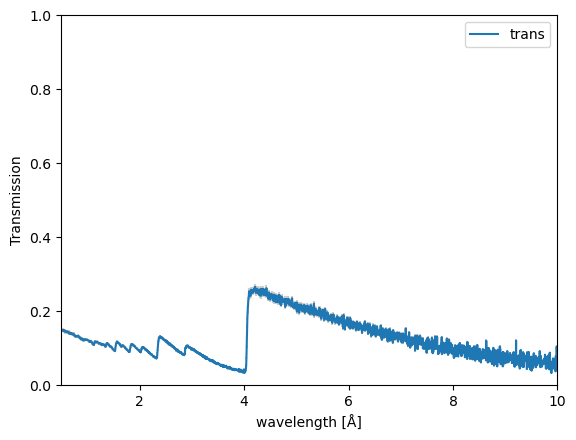

In [6]:
data.plot()

## Define samples
Define the composition of the sample. You can choose predefined crystalline materials from the **NCrystal** standard library, available under the `nbragg.materials` dictionary.

In [7]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

{'mat': 'AgBr_sg225_SilverBromide.ncmat',
 'temp': 300.0,
 'mos': None,
 'dir1': None,
 'dir2': None,
 'dirtol': None,
 'theta': None,
 'phi': None,
 'a': None,
 'b': None,
 'c': None,
 'ext_method': None,
 'ext_l': None,
 'ext_Gg': None,
 'ext_L': None,
 'ext_tilt': None,
 'weight': 1.0,
 '_name': 'SilverBromide',
 '_formula': 'AgBr',
 '_space_group': 'sg225',
 '_url': https://raw.githubusercontent.com/wiki/mctools/ncrystal/datalib/AgBr_sg225_SilverBromide.ncmat.inspect.pdf}

Use the `nbragg.CrossSection` method to load a single material from the library.

In [8]:
gamma = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the NCrystal library using `nbragg.utils.register_material`, then access them from `nbragg.materials` the same way.

In [9]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can combine materials by simple addition. The `cfg_string` will use NCrystal's `phases` syntax to define a multiphase material. Optional weights can be provided by scaling each component.

In [10]:
xs = alpha + gamma

# or with weights
xs = alpha*0.3 + gamma*0.7

In [11]:
xs.cfg_string

'phases<0.3*alpha_Fe_sg229_Iron-alpha.nbragg;temp=300.0K&0.7*gamma_Fe_sg225_Iron-gamma.nbragg;temp=300.0K>'

Access the cross-section data via `xs.table` and plot with `xs.plot()`.

In [12]:
xs.table

,alpha,gamma,total
wavelength,,,
1.00,12.296487,12.429806,12.388762
1.01,12.417385,12.512904,12.483497
1.02,12.418585,12.445530,12.437235
1.03,12.542142,12.210174,12.312376
1.04,12.668032,12.290402,12.406661
...,...,...,...
9.95,15.323228,15.549098,15.479560
9.96,15.338098,15.564084,15.494511
9.97,15.352966,15.579069,15.509460


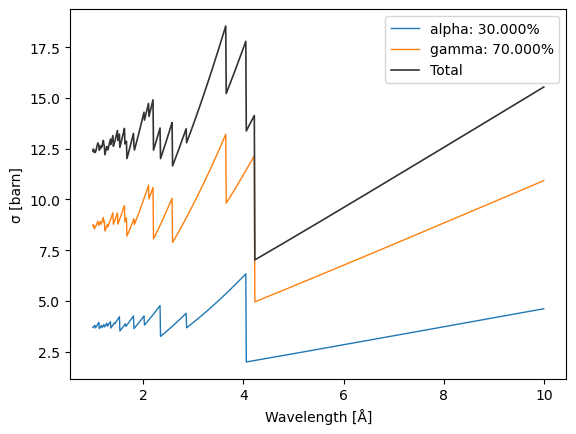

In [13]:
xs.plot();

# Define a transmission model
The fit process in **nbragg** uses the friendly `lmfit` parameter framework.

Construct a `TransmissionModel` from a `CrossSection`, and enable optional model components via flags. Here we vary background, instrument response, and time-of-flight parameters.

In [14]:
model = nbragg.TransmissionModel(alpha, background="polynomial3", vary_background=True, vary_response=True)

In [15]:
model.params  # Inspect default parameter set

name,value,initial value,min,max,vary
thickness,1.00000000,1.0,0.00000000,inf,True
norm,1.00000000,1.0,0.00000000,inf,True
temp,293.150000,293.15,0.00000000,inf,True
α0,3.67000000,3.67,1.0000e-03,10000.0000,True
β0,3.06000000,3.06,1.0000e-03,10000.0000,True
bg0,0.00000000,0.0,-1000000.00,1000000.00,True
bg1,0.00000000,0.0,-1000000.00,1000000.00,True
bg2,0.00000000,0.0,-1000000.00,1000000.00,True


In [16]:
model

Model(transmission)

# Fit
After adjusting parameters (optional), call `model.fit` to perform the fit over a chosen wavelength window. By default, the fit uses the Rietveld method, which accumulates parameters across stages defined in `model.stages`. You can customize the fitting stages to control which parameters are refined in each stage.

In [17]:
# Define custom stages
model.stages = {'basic': ['norm', 'thickness'], 
                'background': 'background', 
                'response': 'response'}
result = model.fit(data, wlmin=1, wlmax=5)

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

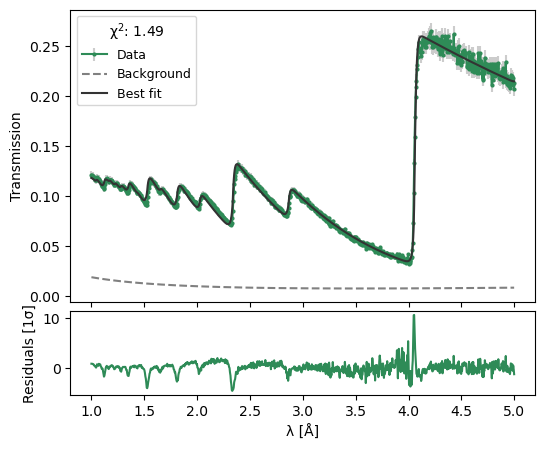

In [18]:
result.plot();

In [19]:
result  # Summary including chi2, parameter values, and uncertainties

# Customizing Fitting Stages
The `TransmissionModel` uses the Rietveld fitting method by default, which refines parameters across multiple stages, accumulating them to improve the fit. You can customize the stages to control which parameters are varied in each stage, allowing you to prioritize certain aspects of the model (e.g., scaling, background, phase weights, or instrument response) and improve convergence. Below, we demonstrate two ways to change the fitting stages using the `xs` cross-section, which combines alpha and gamma iron phases.

## Method 1: Set Stages via `model.stages`
You can define stages by setting the `model.stages` attribute before calling `fit`. This is useful when you want to reuse the same stage configuration for multiple fits.

Here, we define four stages: one for scaling parameters (`norm` and `thickness`), one for background parameters (e.g., `b0`, `b1`), and one for the phase weights.

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

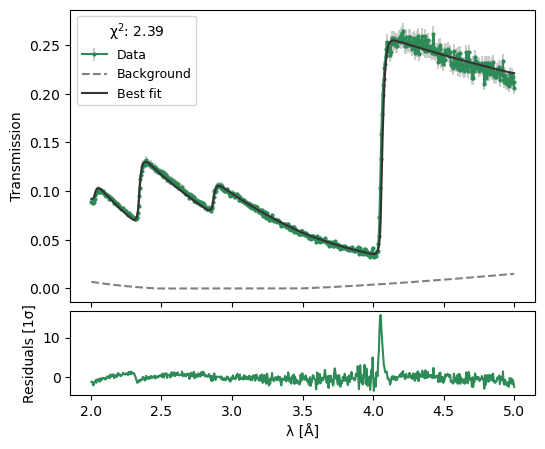

In [20]:
# Create model with weights, background, and response
model = nbragg.TransmissionModel(xs, vary_background=True, vary_weights=True, vary_response=True)

# Define custom stages
model.stages = {
    'scale': ['norm', 'thickness'],
    'background': 'background',
    'weights': ['weights']
}

# Perform fit
result_stages1 = model.fit(data, wlmin=2, wlmax=5)

# Plot results
result_stages1.plot();

In this example, the fit first optimizes the scaling parameters (`norm` and `thickness`), then the background parameters (e.g., `bg0`, `bg1`), followed by the phase weights, and finally the instrument response parameters. The `model.stages` attribute persists, so subsequent calls to `fit` will reuse these stages unless changed.

## Method 2: Pass Stages to `fit`
You can pass a `stages` dictionary directly to the `fit` method to override the default or `model.stages` for a single fit. This is useful for testing different stage configurations without modifying the model.

Here, we use a different approach, first optimizing scaling and background parameters together, then refining phase weights and instrument response parameters in a second stage.

Rietveld Fit:   0%|          | 0/2 [00:00<?, ?it/s]

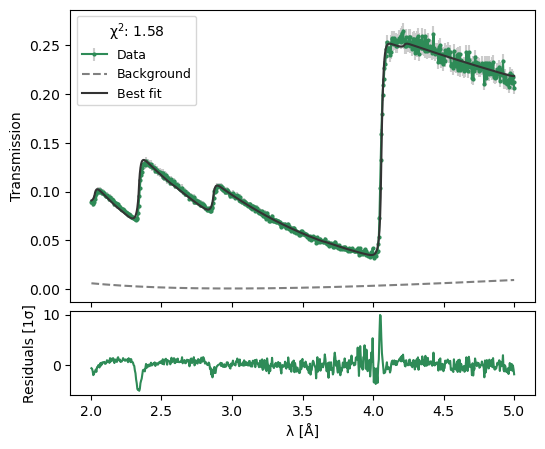

In [21]:
# Create model with weights, background, and response
model = nbragg.TransmissionModel(xs, vary_background=True, vary_weights=True, vary_response=True)

# Define stages for this fit only
stages = {
    'scale_and_background': ['norm', 'thickness', 'bg0', 'bg1', 'bg2'],
    'weights_and_response': ['weights','response']
}

# Perform fit with custom stages
result_stages2 = model.fit(data, wlmin=2, wlmax=5, stages=stages)

# Plot results
result_stages2.plot();

In this example, the fit first optimizes the scaling parameters (`norm`, `thickness`) and background parameters together, then refines the phase weights in a second stage. This can lead to different convergence behavior compared to Method 1. The `stages` argument overrides `model.stages` for this fit only, leaving `model.stages` unchanged for future fits.

> 💡 **Tip:** Use `result.stages_summary` to inspect the parameters and chi-squared values for each stage after fitting.

In [22]:
# Compare stage summaries
print("Method 1 Stages Summary:")
result_stages1.stages_summary

Method 1 Stages Summary:


In [23]:
print("\nMethod 2 Stages Summary:")
result_stages2.stages_summary


Method 2 Stages Summary:


# SANS (Small Angle Neutron Scattering)

**nbragg** supports SANS hard-sphere modeling to account for small-angle scattering contributions. This is useful when samples contain nanoscale features or voids that produce SANS signals.

## Defining and fitting SANS parameters

To add SANS to a material, include the `sans` key with the sphere radius in Angstroms. You can then fit the SANS parameter using `vary_sans=True`.

In [48]:
# Define material with SANS
xs_sans = nbragg.CrossSection({
    'iron': {
        'mat': 'Fe_sg229_Iron-alpha_LGS.ncmat',
        'sans': 50.0  # 50 Angstrom sphere radius
    }
})

# Alternatively, register a material with SANS
nbragg.utils.register_material(sans=xs_sans.materials)
xs_sans_alt = nbragg.CrossSection(aluminum=nbragg.materials['sans_iron'])

# Create model with SANS fitting enabled
model_sans = nbragg.TransmissionModel(xs_sans, vary_response=True, vary_sans=True)

result_sans = model_sans.fit(data, wlmin=1, wlmax=5)  

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

array([<Axes: ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

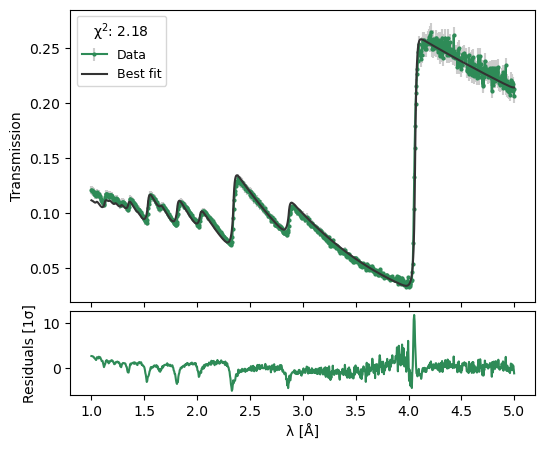

In [49]:
result_sans.plot()

In [50]:
result_sans

**Key points:**
- **SANS parameter**: Hard-sphere radius in Angstroms (bounds: 0-1000)
- **Multi-phase**: Each phase gets its own parameter (`sans1`, `sans2`, etc.)
- **Automatic void phase**: NCrystal automatically adds a small void phase (0.01 fraction) when SANS is enabled
- **Staged refinement**: Include `'sans'` in your custom stages dictionary

> 💡 **Tip:** SANS is most useful for samples with nanoscale features. For purely crystalline samples, SANS modeling may not be necessary.

# Extinction

**nbragg** supports primary and secondary extinction modeling for crystalline materials using NCrystal's CrysExtn plugin. Extinction effects are important for large crystallites or thick samples where multiple scattering becomes significant.

## Defining extinction parameters

Extinction is specified using several parameters:
- `ext_method`: Extinction model (e.g., `'BC_pure'`, `'Sabine_corr'`, `'CR'`)
- `ext_l`: Crystallite size (Angstroms)
- `ext_Gg`: Mosaicity parameter (1/rad)
- `ext_L`: Grain size/path length (Angstroms)
- `ext_dist`: Distribution type for BC models (`'Gauss'`, `'Lorentz'`, `'Fresnel'`)

Has extinction: True


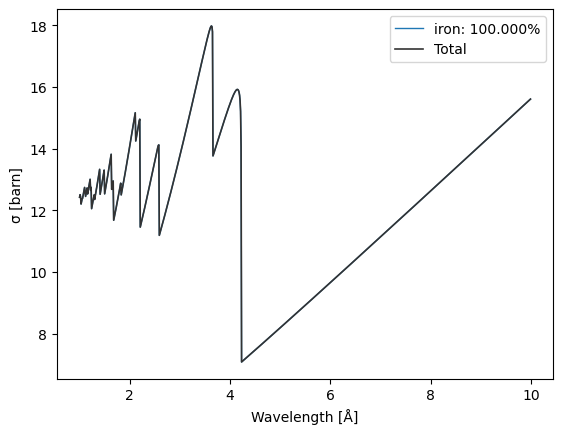

In [64]:
# Define material with extinction
xs_ext = nbragg.CrossSection({
    'iron': {
        'mat': 'Fe_sg225_Iron-gamma.ncmat',
        'ext_method': 'Sabine_uncorr',
        'ext_l': 100.0,      # Crystallite size (Angstroms)
        'ext_Gg': 150.0,      # Mosaicity (1/rad)
        'ext_L': 100000.0,    # Grain size (Angstroms)
        'ext_dist': 'tri'   # Distribution type
    }
})

# Verify extinction is in the NCMAT data
print("Has extinction:", '@CUSTOM_CRYSEXTN' in xs_ext.textdata['iron'])

# You can also update extinction parameters dynamically
xs_ext.materials['iron']['ext_l'] = 3000.0
xs_ext.update()

# Plot to see the effect
xs_ext.plot();

**Supported extinction methods:**
- `BC_pure`, `BC_mix`, `BC_mod`: Becker-Coppens models (require `ext_dist`)
- `Sabine_corr`, `Sabine_uncorr`: Sabine models
- `CR`: Combined reflection model
- `RED`, `RED_orig`: RED models

**Key points:**
- Extinction only applies to crystalline materials (requires structure info)
- Default values are applied if extinction parameters are partially specified
- Extinction parameters can be updated via `xs.materials[material_name][parameter]` followed by `xs.update()`

> 💡 **Tip:** For powder samples or small crystallites (< 1000 Å), extinction effects may be negligible.

# Oriented materials

You can load **oriented** materials by specifying crystal directions relative to the beam axis.

- `dir1`: a crystal direction aligned relative to the beam (assumed z-axis).
- `dir2`: a second crystal direction relative to the y-axis.
- `theta` and `phi`: additional rotations around z and y axes (degrees).
- `mos`: mosaicity (degrees) for each phase.

Below is an example multiphase oriented material.

In [65]:
nbragg.materials["Be_sg194.ncmat"]

{'mat': 'Be_sg194.ncmat',
 'temp': 300.0,
 'mos': None,
 'dir1': None,
 'dir2': None,
 'dirtol': None,
 'theta': None,
 'phi': None,
 'a': None,
 'b': None,
 'c': None,
 'ext_method': None,
 'ext_l': None,
 'ext_Gg': None,
 'ext_L': None,
 'ext_tilt': None,
 'weight': 1.0,
 '_name': 'Be',
 '_formula': 'Be',
 '_space_group': 'sg194',
 '_url': https://raw.githubusercontent.com/wiki/mctools/ncrystal/datalib/Be_sg194.ncmat.inspect.pdf}

In [66]:
gamma =     {
            "mat": "Fe_sg225_Iron-gamma.ncmat",
            "temp": 300,
            "weight": 0.3
            }
beryllium = {
            "mat": "Be_sg194.ncmat",
            "temp": 300,
            "mos": 3,
            "dir1": [0, 0, 1],
            "dir2": [1, 0, 0],
            "theta": 10.0,
            "phi": 10.0,
            "weight": 0.7,
            "dirtol": 30
            }
xs2 = nbragg.CrossSection(gamma=gamma, beryllium=beryllium)

In [67]:
xs2.materials  # Inspect phase definitions

{'gamma': {'mat': 'gamma_Fe_sg225_Iron-gamma.nbragg',
  'temp': 300,
  'mos': None,
  'dir1': None,
  'dir2': None,
  'dirtol': None,
  'theta': None,
  'phi': None,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': None,
  'weight': 0.3,
  '_original_mat': 'Fe_sg225_Iron-gamma.ncmat'},
 'beryllium': {'mat': 'beryllium_Be_sg194.nbragg',
  'temp': 300,
  'mos': 3,
  'dir1': [0, 0, 1],
  'dir2': [1, 0, 0],
  'dirtol': 30,
  'theta': 10.0,
  'phi': 10.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': None,
  'weight': 0.7,
  '_original_mat': 'Be_sg194.ncmat'}}

The configuration string reflects the oriented phases and parameters.

In [68]:
xs2.cfg_string

'phases<0.7*beryllium_Be_sg194.nbragg;dir1=@crys_hkl:0.17364818,0.00000000,0.98480775@lab:0,0,1;dir2=@crys_hkl:0.96984631,0.17364818,-0.17101007@lab:0,1,0;dirtol=30deg;mos=3deg;temp=300K&0.3*gamma_Fe_sg225_Iron-gamma.nbragg;temp=300K>'

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

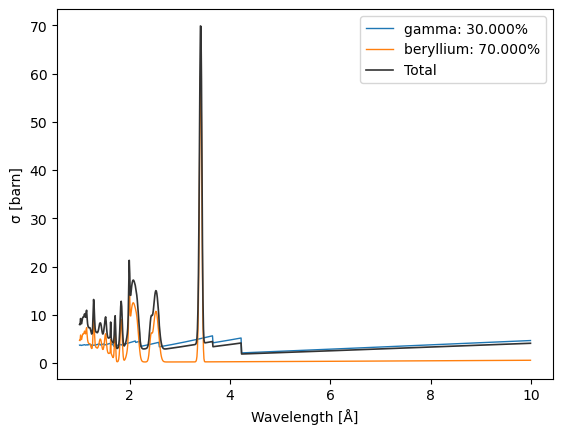

In [69]:
xs2.plot()

Oriented materials can be combined with other (oriented/non-oriented) materials using the same syntax as before.

In [70]:
xs3 = xs2*0.2 + xs*0.8

In [71]:
xs3.phases  # Combined phases

{'alpha': 'alpha_Fe_sg229_Iron-alpha.nbragg;temp=300.0K',
 'beryllium': 'beryllium_Be_sg194.nbragg;dir1=@crys_hkl:0.17364818,0.00000000,0.98480775@lab:0,0,1;dir2=@crys_hkl:0.96984631,0.17364818,-0.17101007@lab:0,1,0;dirtol=30deg;mos=3deg;temp=300K',
 'gamma': 'gamma_Fe_sg225_Iron-gamma.nbragg;temp=300K',
 'gamma_1': 'gamma_1_Fe_sg225_Iron-gamma.nbragg;temp=300.0K'}

<Axes: xlabel='Wavelength [Å]', ylabel='σ [barn]'>

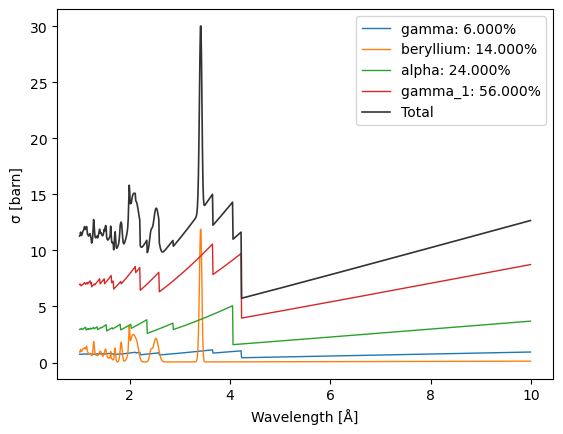

In [72]:
xs3.plot()

# MTEX integration
MTEX (MATLAB) can analyze diffraction peaks to infer phase fractions and textures; those can seed the Bragg-edge model in **nbragg**.

Use the MATLAB scripts in the repository (`mtex_scripts/`) to export predicted phase weights, directions, and mosaicities to CSV. See the **mtex integration README** for details.

The scripts output a CSV with phase weights, orientation vectors, and mosaicity. You can load this with `nbragg.CrossSection.from_mtex` to create a multiphase `CrossSection`.

In [73]:
xs_alpha = nbragg.CrossSection.from_mtex(
    "sf_alpha_ncrystal.csv",
    nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"],
    short_name="α",
)

xs_gamma = nbragg.CrossSection.from_mtex(
    "sf_gamma_ncrystal.csv",
    nbragg.materials["Fe_sg225_Iron-gamma_LGS.ncmat"],
    short_name="γ",
)

In [74]:
xs_gamma.materials  # Inspect the phases imported from MTEX

{'γ0': {'mat': 'γ0_Fe_sg225_Iron-gamma_LGS.nbragg',
  'temp': 300.0,
  'mos': np.float64(18.587635),
  'dir1': [0.6441900482655264, -0.42660643576314217, 0.6348433906729493],
  'dir2': [0.5657658668405976, 0.8243193609334006, -0.02016370770610611],
  'dirtol': 1.0,
  'theta': 0.0,
  'phi': 0.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': None,
  'weight': 0.25650124,
  '_original_mat': 'Fe_sg225_Iron-gamma_LGS.ncmat'},
 'γ1': {'mat': 'γ1_Fe_sg225_Iron-gamma_LGS.nbragg',
  'temp': 300.0,
  'mos': np.float64(20.339102),
  'dir1': [0.854099240380397, 0.5090663732331492, -0.10661104644865317],
  'dir2': [-0.512933562842995, 0.8583625620276916, -0.010624133774035573],
  'dirtol': 1.0,
  'theta': 0.0,
  'phi': 0.0,
  'a': None,
  'b': None,
  'c': None,
  'ext_method': None,
  'ext_l': None,
  'ext_Gg': None,
  'ext_L': None,
  'ext_dist': None,
  'sans': None,
  'weight': 0.16803913,
  '_origi

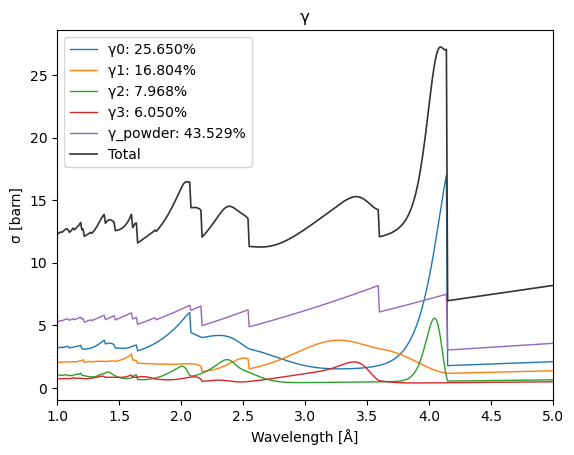

In [75]:
xs_gamma.plot(xlim=(1, 5));

# Fitting Large-Grain Steel Data


We'll use the MTEX-generated materials to fit a multiphase large-grain steel sample.

## Load data
Use `nbragg.Data.from_counts(signal_csv, openbeam_csv)` with two CSV files: the sample **signal** and the **open-beam** reference.

Each CSV should have three columns:
- **slice**: Identifier for each slice of the sample,
- **counts**: Measured counts for each slice,
- **error**: Measurement error associated with each count value.

In [76]:
data = nbragg.Data.from_counts("large_grain_steel_0deg.csv", "openbeam.csv")

<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

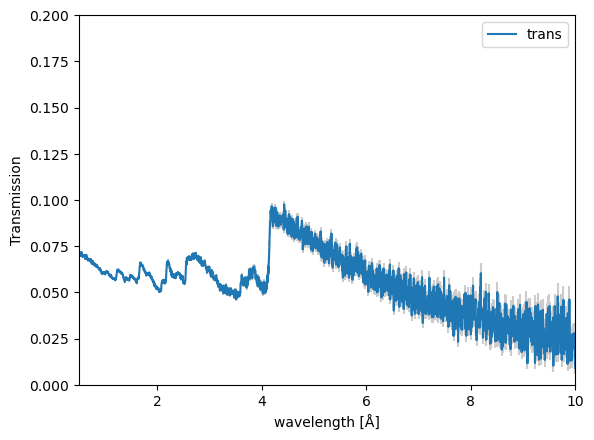

In [77]:
data.plot(ylim=(0, 0.2))

Define a model based on the MTEX-derived **iron-gamma** cross section.

In [78]:
model = nbragg.TransmissionModel(xs_gamma, vary_background=True, vary_weights=True)

In [79]:
model.params["norm"].value = 1.0/2.3
model.params["thickness"].value = 1.27
model.params["thickness"].vary = True
model.params  # Review current parameters

name,value,initial value,min,max,vary,expression
thickness,1.27000000,1.0,0.00000000,inf,True,
norm,0.43478261,1.0,0.00000000,inf,True,
temp,293.150000,293.15,0.00000000,inf,True,
p1,-0.52887420,-0.5288741982897172,-14.0000000,14.0000000,True,
p2,-0.95181083,-0.9518108282477983,-14.0000000,14.0000000,True,
p3,-1.69803590,-1.6980358972652292,-14.0000000,14.0000000,True,
p4,-1.97343971,-1.9734397069014835,-14.0000000,14.0000000,True,
γ0,0.25650124,None,-inf,inf,False,exp(p1) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ1,0.16803913,None,-inf,inf,False,exp(p2) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))
γ2,0.07967627,None,-inf,inf,False,exp(p3) / (1 + exp(p1) + exp(p2) + exp(p3) + exp(p4))


In [80]:
result = model.fit(data, wlmin=2, wlmax=5)

Rietveld Fit:   0%|          | 0/3 [00:00<?, ?it/s]

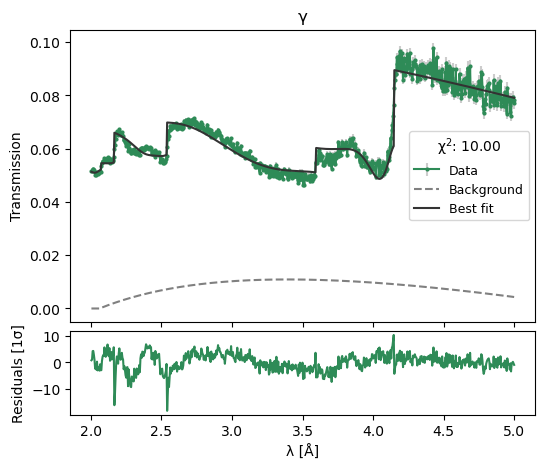

In [81]:
result.plot();

In [82]:
result

Now we also vary the **orientation**.

In [83]:
model = nbragg.TransmissionModel(
    xs_gamma,
    vary_background=True,
    vary_weights=True,
    vary_orientation=True,
)
# Example: reuse previous best params (optional)
model.update_params(result.params)
model.params["thickness"].vary = False
model.params["norm"].vary = False
model.params

name,value,initial value,min,max,vary
thickness,0.73133673,0.7313367259258496,0.00000000,inf,False
norm,0.12568016,0.12568016219446276,0.00000000,inf,False
temp,293.150000,293.15,0.00000000,inf,True
p1,-13.8818866,-13.881886615840475,-14.0000000,14.0000000,True
p2,-0.88827100,-0.8882710000971894,-14.0000000,14.0000000,True
p3,-2.18321647,-2.1832164660943096,-14.0000000,14.0000000,True
p4,-6.60226729,-6.602267294895284,-14.0000000,14.0000000,True
γ0,6.1346e-07,6.134633331661677e-07,-inf,inf,False
γ1,0.26967716,0.26967716367648636,-inf,inf,False
γ2,0.07386803,0.07386802739933201,-inf,inf,False


In [84]:
model.stages

{'basic': 'basic',
 'background': 'background',
 'mosaicity': 'mosaicity',
 'thetas': 'thetas',
 'phis': 'phis',
 'angles': 'angles',
 'orientation': 'orientation',
 'weights': 'weights'}

In [85]:
model.stages = {'basic': 'basic',
 'background': 'background',
 # 'mosaicity': 'mosaicity',
 'thetas': 'thetas',
 # 'phis': 'phis',
 # 'angles': 'angles',
 # 'orientation': 'orientation',
 'weights': 'weights'}
result2 = model.fit(data, wlmin=2, wlmax=5)

Rietveld Fit:   0%|          | 0/4 [00:00<?, ?it/s]

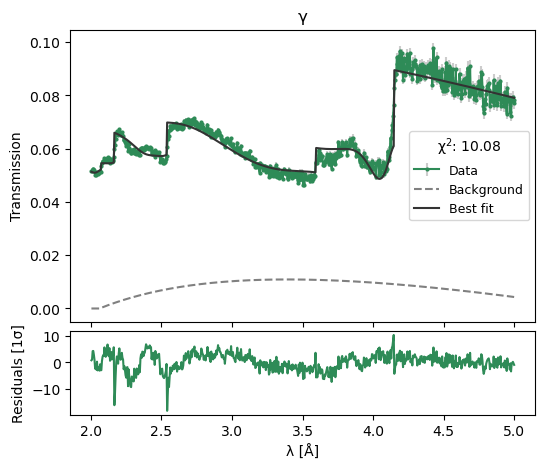

In [86]:
result2.plot();